<h2 style="text-align: center;"><b>K Nearest Neighbors (KNN)</b></h2>

Метод ближайших соседей (k Nearest Neighbors, или kNN) — очень популярный метод классификации, также иногда используемый в задачах регрессии. Это один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей; какие преобладают --- таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

<img src='https://hsto.org/web/68d/a45/6f0/68da456f00f8434e87628dbe7e3f54a7.png' width=600>


Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей

Будем работать с подвыборкой из [данных о типе лесного покрытия из репозитория UCI](http://archive.ics.uci.edu/ml/datasets/Covertype). Доступно 7 различных классов. Каждый объект описывается 54 признаками, 40 из которых являются бинарными. Описание данных доступно по ссылке.

### Обработка данных

In [49]:
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import ConvergenceWarning

# Игнорирование предупреждений о сходимости
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Сcылка на датасет (лежит в папке): https://drive.google.com/drive/folders/16TSz1P-oTF8iXSQ1xrt0r_VO35xKmUes?usp=sharing

In [2]:
all_data = pd.read_csv('forest_dataset.csv')
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [3]:
all_data.shape

(10000, 55)

Выделим значения метки класса в переменную `labels`, признаковые описания --- в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в `numpy`-формат с помощью метода `.values`.

In [7]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

set(labels)

{1, 2, 3, 4, 5, 6, 7}

In [6]:
feature_matrix

array([[2683,  333,   35, ...,    0,    0,    0],
       [2915,   90,    8, ...,    0,    0,    0],
       [2941,  162,    7, ...,    0,    0,    0],
       ...,
       [2693,   21,   11, ...,    0,    0,    0],
       [2536,   42,   11, ...,    0,    0,    0],
       [3109,  261,   10, ...,    0,    0,    0]])

### Пара слов о sklearn

**[sklearn](https://scikit-learn.org/stable/index.html)** -- удобная библиотека для знакомства с машинным обучением. В ней реализованны большинство стандартных алгоритмов для построения моделей и работ с выборками. У неё есть подробная документация на английском, с которой вам придётся поработать.

`sklearn` предпологает, что ваши выборки имеют вид пар $(X, y)$, где $X$ -- матрица признаков, $y$ -- вектор истинных значений целевой переменной, или просто $X$, если целевые переменные неизвестны.

Познакомимся со вспомогательной функцией 
[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
С её помощью можно разбить выборку на обучающую и тестовую части.

In [8]:
from sklearn.model_selection import train_test_split

Вернёмся к датасету. Сейчас будем работать со всеми 7 типами покрытия (данные уже находятся в переменных `feature_matrix` и `labels`, если Вы их не переопределили). Разделим выборку на обучающую и тестовую с помощью метода `train_test_split`.

In [9]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

Параметр `test_size` контролирует, какая часть выборки будет тестовой. Более подробно о нём можно прочитать в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Основные объекты `sklearn` -- так называемые `estimators`, что можно перевести как *оценщики*, но не стоит, так как по сути это *модели*. Они делятся на **классификаторы** и **регрессоры**.

В качестве примера модели можно привести классификаторы
[метод ближайших соседей](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) и 
[логистическую регрессию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Что такое логистическая регрессия и как она работает сейчас не важно.

У всех моделей в `sklearn` обязательно должно быть хотя бы 2 метода (подробнее о методах и классах в python будет в следующих занятиях) -- `fit` и `predict`.

Метод `fit(X, y)` отвечает за обучение модели и принимает на вход обучающую выборку в виде *матрицы признаков* $X$ и *вектора ответов* $y$.

У обученной после `fit` модели теперь можно вызывать метод `predict(X)`, который вернёт предсказания этой модели на всех объектах из матрицы $X$ в виде вектора.

Вызывать `fit` у одной и той же модели можно несколько раз, каждый раз она будет обучаться заново на переданном наборе данных.

Ещё у моделей есть *гиперпараметры*, которые обычно задаются при создании модели.

Рассмотрим всё это на примере логистической регрессии.

In [15]:
from sklearn.linear_model import LogisticRegression

In [22]:
# создание модели с указанием гиперпараметра C
clf = LogisticRegression(C=1)
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
y_pred = clf.predict(test_feature_matrix)

/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Сообщение "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT" указывает на то, что обучение логистической регрессии завершилось из-за достижения максимального числа итераций (max_iter). Это может произойти, если модель не смогла сойтись к оптимальным весам за заданное количество итераций.

Чтобы решить эту проблему, можно попробовать увеличить значение параметра max_iter в коде, например:

In [29]:
# создание модели с указанием гиперпараметра C и max_iter
clf = LogisticRegression(C=1, max_iter=10000000)
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
y_pred = clf.predict(test_feature_matrix)

/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Предупреждение "ConvergenceWarning" указывает на то, что оптимизационный алгоритм (в данном случае, lbfgs) не смог сойтись к оптимальным весам модели. Это может произойти из-за различных причин, таких как наличие коллинеарности в данных или неоптимальной настройки гиперпараметров.

Используем другой метод оптимизации: Вместо lbfgs попробуем другие методы оптимизации, такие как 'liblinear' или 'newton-cg':

In [41]:
# создание модели с указанием гиперпараметра C и max_iter
clf = LogisticRegression(C=1, solver='liblinear', max_iter=10000)
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
y_pred = clf.predict(test_feature_matrix)

Теперь хотелось бы измерить качество нашей модели. Для этого можно использовать метод `score(X, y)`, который посчитает какую-то функцию ошибки на выборке $X, y$, но какую конкретно уже зависит от модели. Также можно использовать одну из функций модуля `metrics`, например [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), которая, как понятно из названия, вычислит нам точность предсказаний.

In [42]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

0.6995

Наконец, последним, о чём хотелось бы упомянуть, будет перебор гиперпараметров по сетке. Так как у моделей есть много гиперпараметров, которые можно изменять, и от этих гиперпараметров существенно зависит качество модели, хотелось бы найти наилучшие в этом смысле параметры. Самый простой способ это сделать -- просто перебрать все возможные варианты в разумных пределах.

Сделать это можно с помощью класса [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), который осуществляет поиск (search) по сетке (grid) и вычисляет качество модели с помощью кросс-валидации (CV).

У логистической регрессии, например, можно поменять параметры `C` и `penalty`. Сделаем это. Учтите, что поиск может занять долгое время. Смысл параметров смотрите в документации.

In [43]:
from sklearn.model_selection import GridSearchCV

In [50]:
# заново создадим модель, указав солвер
clf = LogisticRegression(solver='saga')

# опишем сетку, по которой будем искать
param_grid = {
    'C': np.arange(1, 5), # также можно указать обычный массив, [1, 2, 3, 4]
    'penalty': ['l1', 'l2'],
}

# создадим объект GridSearchCV
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

# запустим поиск
search.fit(feature_matrix, labels)

# выведем наилучшие параметры
print(search.best_params_)

/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bromotdi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bromotdi/anaconda3/lib/python3.11/site-pack

{'C': 1, 'penalty': 'l2'}


В данном случае, поиск перебирает все возможные пары значений C и penalty из заданных множеств.

In [45]:
accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

0.6419

Заметьте, что мы передаём в GridSearchCV всю выборку, а не только её обучающую часть. Это можно делать, так как поиск всё равно использует кроссвалидацию. Однако порой от выборки всё-же отделяют *валидационную* часть, так как гиперпараметры в процессе поиска могли переобучиться под выборку.

В заданиях вам предстоит повторить это для метода ближайших соседей.

### Обучение модели

Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:

* число соседей `n_neighbors`
* метрика расстояния между объектами `metric`
* веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос") `weights`


Обучите на датасете `KNeighborsClassifier` из `sklearn`.

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier()
# обучение модели
clf.fit(train_feature_matrix, train_labels)
# предсказание на тестовой выборке
y_pred = clf.predict(test_feature_matrix)

In [53]:
accuracy_score(test_labels, y_pred)

0.7365

### Вопрос 1:
* Какое качество у вас получилось?

Подберём параметры нашей модели

* Переберите по сетке от `1` до `10` параметр числа соседей

* Также вы попробуйте использоввать различные метрики: `['manhattan', 'euclidean']`

* Попробуйте использовать различные стратегии вычисления весов: `[‘uniform’, ‘distance’]`

In [60]:
# Описание сетки поиска
param_grid = {
    'n_neighbors': range(1, 11),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

# Создание объекта GridSearchCV
knn_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, scoring='accuracy')

# Запуск поиска
knn_search.fit(feature_matrix, labels)

# Вывод результатов для каждой метрики
results = knn_search.cv_results_
for params, score in zip(results['params'], results['mean_test_score']):
    print(f"Параметры: {params}, Средняя оценка теста: {score}")

Параметры: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}, Средняя оценка теста: 0.7817000000000001
Параметры: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}, Средняя оценка теста: 0.7817000000000001
Параметры: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}, Средняя оценка теста: 0.7396
Параметры: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}, Средняя оценка теста: 0.7819
Параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}, Средняя оценка теста: 0.7635
Параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}, Средняя оценка теста: 0.7802
Параметры: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'uniform'}, Средняя оценка теста: 0.7493
Параметры: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}, Средняя оценка теста: 0.7871
Параметры: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}, Средняя оценка теста: 0.7512000000000001
Параметры: {'me

Давайте разберем каждый из параметров:
1. **clf (classifier):** классификатор
2. **param_grid (parametric grid):** cловарь параметров
3. **n_jobs:** количество параллельных задач 
    - `-1` означает использование всех доступных процессоров.
4. **cv (cross-validation):** количество разбиений при кросс-валидации: 
    -  данные разбиваются на 5 частей, и модель обучается и тестируется 5 раз, каждый раз на различных подмножествах данных.
5. **scoring:** метрика

Выведем лучшие параметры

In [61]:
knn_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

### Вопрос 2:
* Какую metric следует использовать?

1. **Manhattan Distance (`'manhattan'`):**
   - Также известно как "городское расстояние" или "L1 норма".
   - Вычисляется как сумма абсолютных различий между координатами точек.

2. **Euclidean Distance (`'euclidean'`):**
   - Также известно как "евклидово расстояние" или "L2 норма".
   - Вычисляется как длина прямой линии между двумя точками.

3. **Chebyshev Distance (`'chebyshev'`):**
   - Расстояние Чебышева вычисляется как максимальная разница между соответствующими координатами точек.

4. **Minkowski Distance (`'minkowski'`):**
   - Обобщение расстояния Чебышева и евклидова расстояния.
   - Параметр `p` используется для настройки степени Минковского. При `p=1` это эквивалентно манхэттенскому расстоянию, при `p=2` - евклидову расстоянию.

5. **Hamming Distance (`'hamming'`):**
   - Используется для измерения расстояния между двумя строками одинаковой длины, считая количество несовпадающих элементов.

6. **Cosine Similarity (`'cosine'`):**
   - Измеряет косинус угла между двумя векторами. Используется для измерения сходства между двумя ненулевыми векторами.

7. **Jaccard Similarity (`'jaccard'`):**
   - Измеряет сходство между двумя множествами как отношение размера пересечения к размеру объединения множеств.

8. **Mahalanobis Distance (`'mahalanobis'`):**
   - Измеряет расстояние между точкой и центром данных с учетом ковариации между признаками.

In [63]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

# обучение модели
knn.fit(train_feature_matrix, train_labels)

# предсказание на тестовой выборке
y_pred = knn.predict(test_feature_matrix)

In [66]:
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy}')

from sklearn.metrics import f1_score
f1 = f1_score(test_labels, y_pred, average='weighted')  # или average='micro' или average='macro'
print(f'F1 Score: {f1}')

Accuracy: 0.785
F1 Score: 0.7828452671054947


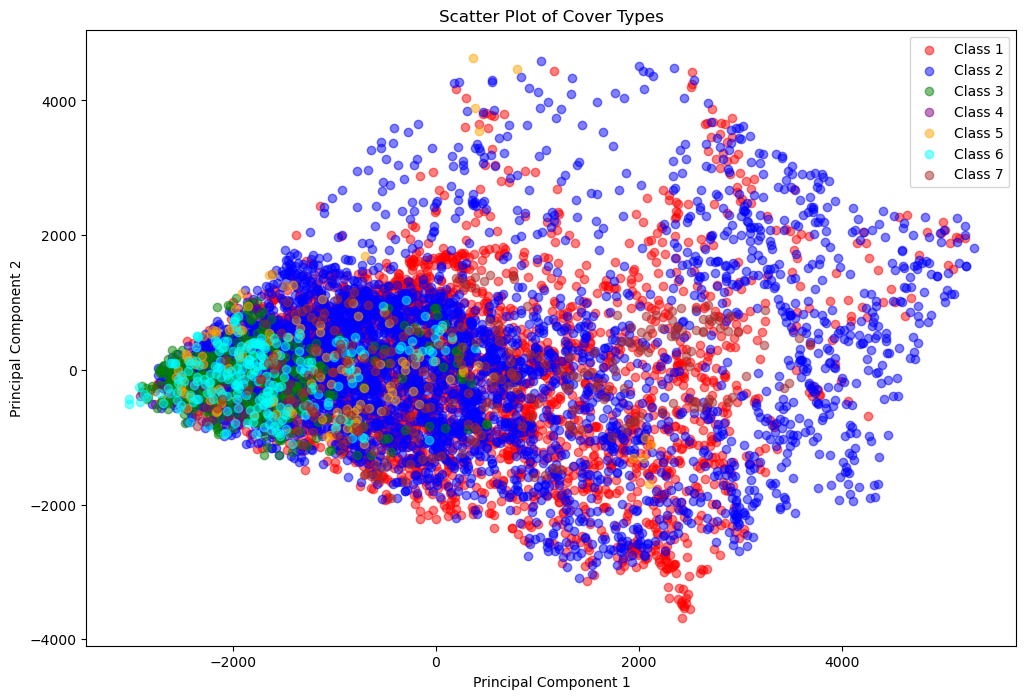

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Уменьшение размерности до двух компонент с использованием PCA
pca = PCA(n_components=2)
X_2D = pca.fit_transform(train_feature_matrix)  # Используйте X_train здесь, чтобы размерности совпадали с y_train

# Построение графика классов
plt.figure(figsize=(12, 8))

# Различные цвета для различных классов (первые 7)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown']

for label, color in zip(range(1, 8), colors):
    plt.scatter(X_2D[train_labels == label, 0], X_2D[train_labels == label, 1], label=f'Class {label}', color=color, alpha=0.5)

# Подписи
plt.title('Scatter Plot of Cover Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Отображение легенды
plt.legend()

# Показать график
plt.show()

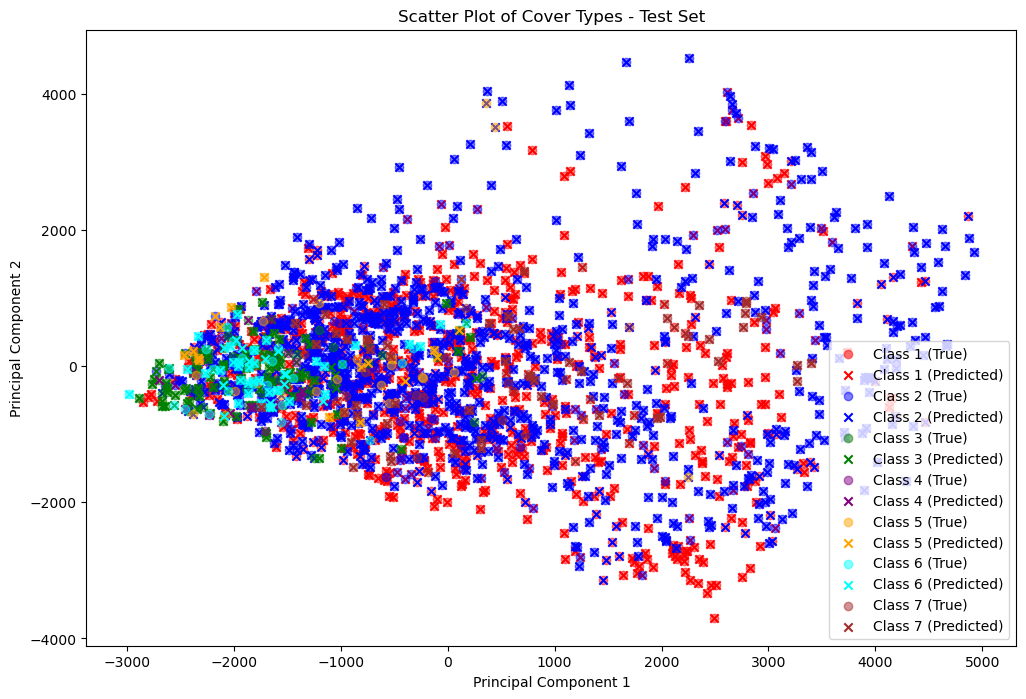

In [72]:
# Уменьшение размерности до двух компонент с использованием PCA
X_test_2D = pca.transform(test_feature_matrix)

# Построение графика классов
plt.figure(figsize=(12, 8))

# Различные цвета для различных классов (первые 7)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'brown']

for label, color in zip(range(1, 8), colors):
    plt.scatter(X_test_2D[test_labels  == label, 0], X_test_2D[test_labels  == label, 1], label=f'Class {label} (True)', color=color, alpha=0.5)
    plt.scatter(X_test_2D[y_pred == label, 0], X_test_2D[y_pred == label, 1], marker='x', label=f'Class {label} (Predicted)', color=color)

# Подписи
plt.title('Scatter Plot of Cover Types - Test Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Отображение легенды
plt.legend()

# Показать график
plt.show()


### Вопрос 3:
* Сколько n_neighbors следует использовать?

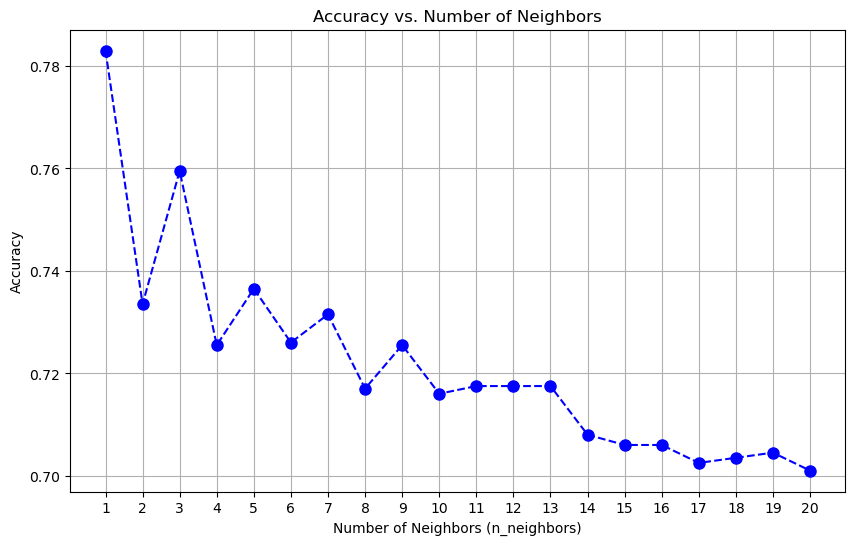

In [79]:
from sklearn.model_selection import cross_val_score

# Создание списка значений n_neighbors, которые вы хотите проверить
neighbors_range = range(1, 21)

# Создание списка для сохранения средних оценок кросс-валидации для каждого значения n_neighbors
cv_scores = []

# Вычисление средней оценки кросс-валидации для каждого значения n_neighbors
for n_neighbors in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_feature_matrix, train_labels)
    y_pred = knn.predict(test_feature_matrix)
    accuracy = accuracy_score(test_labels, y_pred)
    cv_scores.append(accuracy.mean())

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, cv_scores, marker='o', linestyle='dashed', color='blue', markersize=8)
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Accuracy')
plt.xticks(neighbors_range)  # Установка значений на оси x как целых чисел
plt.grid(True)
plt.show()

### Вопрос 4:
* Какой тип weights следует использовать?

1. **Uniform (равномерные веса):**
   - В этом случае, каждый сосед вносит одинаковый вклад в классификацию.
   - По умолчанию (`weights='uniform'`), и это часто используется в ситуациях, когда все соседи считаются равнозначными.

2. **Distance (веса по расстоянию):**
   - Здесь вклад каждого соседа в классификацию зависит от его расстояния до точки, которую мы классифицируем. Ближайшие соседи имеют больший вес, чем дальние.
   - Указывается с помощью `weights='distance'`.

Используя найденное оптимальное число соседей, вычислите вероятности принадлежности к классам для тестовой выборки (`.predict_proba`).

In [90]:
optimal_clf = KNeighborsClassifier(n_neighbors=4)

# обучение модели
optimal_clf.fit(train_feature_matrix, train_labels)

# предсказание на тестовой выборке
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

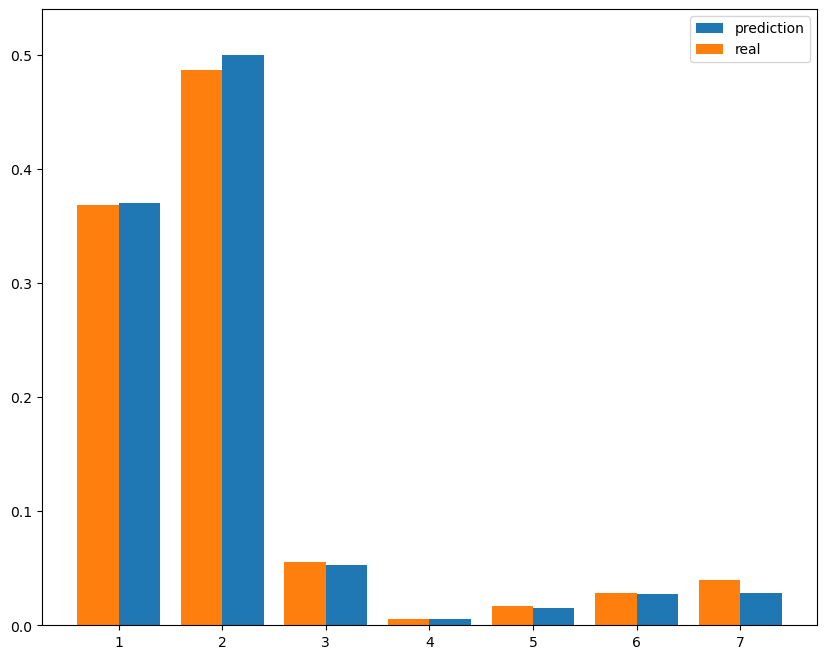

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

### Вопрос 5:
* Какая прогнозируемая вероятность pred_freq класса под номером 3 (до 2 знаков после запятой)?

In [94]:
# Определение индекса класса под номером 3
class_index = 2

# Вывод прогнозируемой вероятности класса под номером 3 (округленной до 2 знаков после запятой)
print(f"Прогнозируемая вероятность класса {class_index + 1}: {pred_freq[class_index]:.2f}")


Прогнозируемая вероятность класса 3: 0.05
